In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
#%matplotlib widget

In [3]:
# Set seed for reproducibility
torch.manual_seed(42);

# PyTorch Full Regression Example


## Synthetic Data Generation

We generate some synthetic data from the function. 

$$ y = 2 \sin(3x) - 3 \cos(7x) $$

In a real-world example you would instead load some real data from an external source (eg, .mat or .csv file).

In [4]:
# Synthetic data parameters
nx = 1
ny = 1
a = -1
b = 1
n_samples = 10_000
sigma_e = 0.1

In [5]:
# Function to be learned
def f(x):
    return 2*torch.sin(3*x)  - 3*torch.cos(7*x)

In [6]:
# Training data
x_train = a + torch.rand((n_samples, 1))*(b - a)
y_train = f(x_train) + sigma_e*torch.randn((n_samples, 1))
x_train.shape, y_train.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [7]:
# Test data
x_test = a + torch.rand((n_samples, 1))*(b - a)
y_test = f(x_test) + sigma_e*torch.randn((n_samples, 1))
x_test.shape, y_test.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

## Data Visualization

It's always a good idea to start by visualizing your dataset. For 1D data, this is pretty trivial

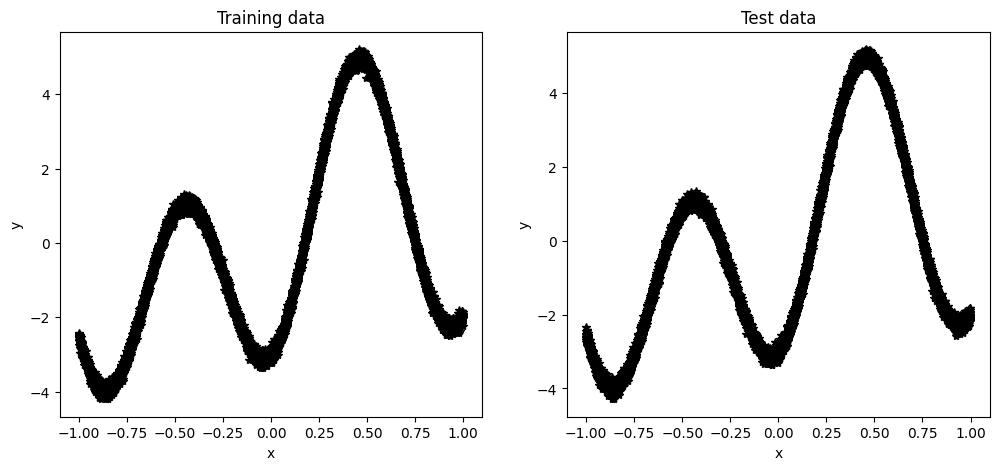

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Training data")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].plot(x_train, y_train, "k*");
ax[1].set_title("Test data")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].plot(x_test, y_test, "k*");

A neural network may be an overkill here, but toy examples are good to learn!

## Preprocessing

While in this example input and output values are in a reasonable numerical range, it is generally good to scale the data before training. We could either do it manually or use the Scalers of scikit-learn.

In [9]:
# Manual standardization
x_mean, x_std = x_train.mean(), x_train.std()
x_train_sc = (x_train - x_mean)/x_std
x_test_sc = (x_test - x_mean)/x_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train_sc = (y_train - y_mean)/y_std
y_test_sc = (y_test - y_mean)/y_std

x_train_sc.std(), x_test_sc.std()

(tensor(1.), tensor(0.9995))

In [10]:
# from sklearn.preprocessing import StandardScaler
# scaler_x = StandardScaler()
# x_train_sc = scaler_x.fit_transform(x_train) # standardize training x using training mean and std
# x_test_sc = scaler_x.transform(x_test) # standardize test x using training mean and std

# scaler_y = StandardScaler()
# y_train_sc = scaler_y.fit_transform(y_train)    
# y_test_sc = scaler_y.transform(y_test)

## Training

The actual training in PyTorch is a lot of boilerplate code. Let us first fix some hyper-parameters:

In [11]:
# Training hyper-parameters
hidden_size = 16
epochs = 200
learning_rate = 1e-2
batch_size = 256

Let us define a feed-forward (FF) neural network, a.k.a. multi-layer perceptron (MLP)

\begin{align} 
&y = W_2\tanh(W_1 x + b_1) + b_2 \\
&W_1\in \mathbb{R}^{\text{hidden\_size} \times 1}, b_1 \in \mathbb{R}^{\text{hidden\_size}}, W_2 \in \mathbb{R}^{1 \times \text{hidden\_size} }, b_2 \in \mathbb{R}
\end{align}

In [12]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(nx, hidden_size) 
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, ny)

    def forward(self, x):
        x = self.act1(self.fc1(x)) # 16
        x = self.fc2(x) # 1
        return x

model = FeedForwardNN()

Let us define the Dataset, DataLoader, Loss, and optimizer

In [13]:
# Dataset, DataLoader Loss, and Optimizer

train_ds = TensorDataset(x_train_sc, y_train_sc)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
criterion = nn.MSELoss() # we may also define the loss manually in the training loop
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

With all the ingredients ready, training is just a standard for loop

In [ ]:
# Train the model
LOSS = []
for epoch in range(epochs): # run for a number of epochs. At each epoch we run through the entire training set
    
    loss_epoch = 0.0 # just for diagnostic, we track the average loss in the training epoch
    for batch_x, batch_y in train_dl: # extract a minibatch and run an iteration
        optimizer.zero_grad() # reset gradients in the .grad attribute of the model parameters, otherwise they accumulate
        
        batch_y_pred = model(batch_x)
        loss = criterion(batch_y_pred, batch_y)
        # loss = torch.mean((batch_y_pred - batch_y)**2) 

        loss.backward() # compute gradients with back-propagation
        optimizer.step() # run a gradient-based optimization step
        
        loss_epoch += loss.item()
        
    loss_epoch /= len(train_dl) # divide by number of batches per epoch to get an average
    LOSS.append(loss_epoch)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_epoch:.4f}", end="\r") # diagnostic output (once per epoch here)

In [15]:
batch_x.shape, batch_y.shape

(torch.Size([256, 1]), torch.Size([256, 1]))

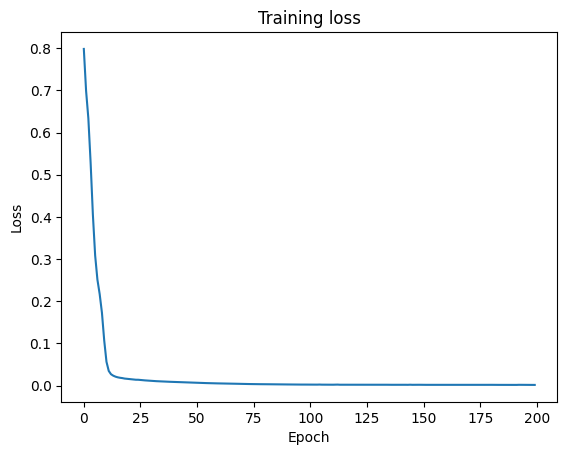

In [16]:
plt.figure()
plt.plot(LOSS)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Model assessment

It is crucial to evaluate the model performance on the test set. Training set performance may also be useful (eg to assess under- and over-fitting).

In [17]:
# Generate model prediction on the test set (optionally also on the training set)
with torch.no_grad():
    y_test_hat_sc = model(x_test_sc) # model accepts normalized x

y_test_hat = y_test_hat_sc * y_std + y_mean # inverse transform to get y in the original scale

#y_test_hat = scaler_y.inverse_transform(y_test_hat_sc) # with scikit-learn you don't need to remember scaling formulas

In [18]:
rsme = torch.sqrt(torch.mean((y_test_hat - y_test)**2))
print(f"RSME: {rsme:.3f}") # note: sigma_e = 0.1, so RSME can hardly be smaller than that

RSME: 0.110


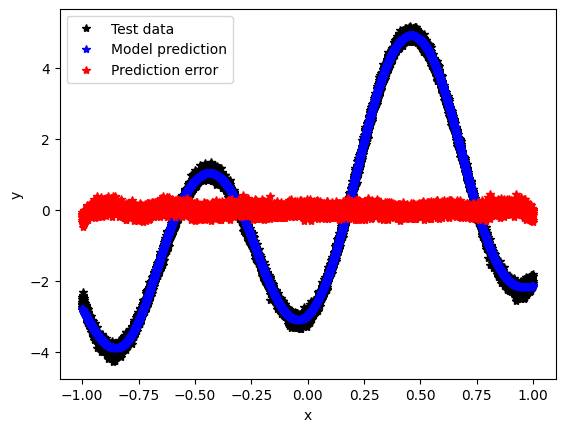

In [19]:
plt.figure()
plt.plot(x_test, y_test, "k*", label="Test data")
plt.plot(x_test, y_test_hat, "b*", label="Model prediction")
plt.plot(x_test, y_test_hat - y_test, "r*", label="Prediction error")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

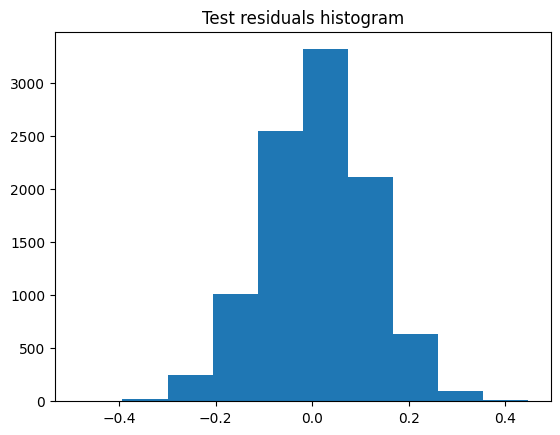

In [20]:
plt.figure()
plt.title("Test residuals histogram")
plt.hist(y_test_hat - y_test);

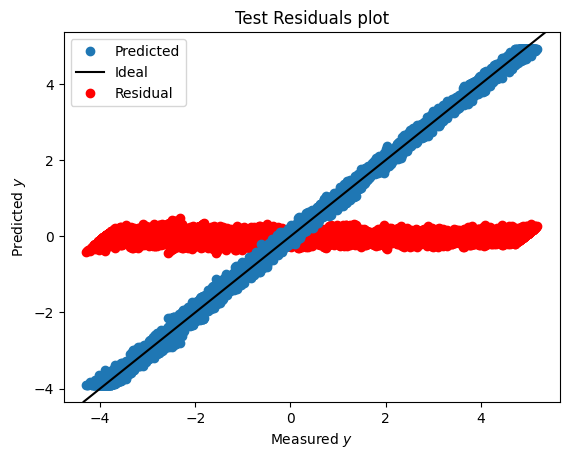

In [21]:
plt.figure()
plt.title('Test Residuals plot')
plt.plot(y_test, y_test_hat, 'o', label='Predicted', zorder=1)
plt.axline((1, 1), slope=1, color="k", label="Ideal", zorder=2) # the ideal diagonal prediction
plt.plot(y_test, y_test - y_test_hat, 'ro', label='Residual', zorder=0)
plt.legend()
plt.xlabel('Measured $y$')
plt.ylabel('Predicted $y$');

## Exercise

Familiarize with the code. Experiment with different:
- number of hidden layers
- number of neurons
- optimizers
- learning rates
- number of epochs

You may also modify the true function, domain bounds, etc.